<a href="https://colab.research.google.com/github/miles-garcia/DSPS_MGarcia/blob/main/PHYS661_HW10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
import numpy as np
tf.__version__

'2.15.0'

In [2]:
import scipy
from scipy import io
from scipy.interpolate import griddata
import pylab as pl

In [3]:
!wget https://github.com/maziarraissi/PINNs/raw/master/appendix/Data/burgers_shock.mat

--2023-12-19 19:32:44--  https://github.com/maziarraissi/PINNs/raw/master/appendix/Data/burgers_shock.mat
Resolving github.com (github.com)... 20.205.243.166
Connecting to github.com (github.com)|20.205.243.166|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/maziarraissi/PINNs/master/appendix/Data/burgers_shock.mat [following]
--2023-12-19 19:32:45--  https://raw.githubusercontent.com/maziarraissi/PINNs/master/appendix/Data/burgers_shock.mat
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 207944 (203K) [application/octet-stream]
Saving to: ‘burgers_shock.mat’

burgers_shock.mat   100%[===================>] 203.07K  --.-KB/s    in 0.003s  

2023-12-19 19:32:45 (60.4 MB/s) - ‘burgers_shock.mat’ s

(100,) (256,) (256, 100)


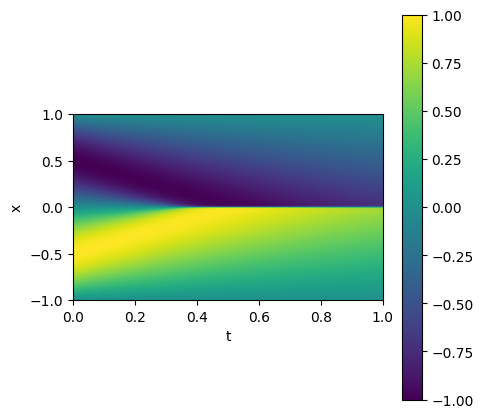

In [4]:
### what is the solution that we want? read in the data

# loading in a file saved as a binary (?) in mathematica
data = scipy.io.loadmat('burgers_shock.mat')

data.keys()

t = data['t'].flatten() #time
x = data['x'].flatten() #position
Z = np.real(data['usol']) #solution of Burger's Ee

print(t.shape, x.shape, Z.shape)

ax = pl.figure(figsize=(5,5)).add_subplot(111)
cb = ax.imshow(Z[::-1],extent=[0,1,-1,1], clim=(-1,1))
ax.set_xlabel("t")
ax.set_ylabel("x");
ax.set_aspect(0.3)
pl.colorbar(cb);


Figure 1. This is the solution to the Burger Equations that we're looking to find using the PINN. We can see the evidence of the shock front at x=0. The colorbar represents u(x,t), the velocity of the particles at position x and time t. This colorbar will remain the same for future plots.

# PROBLEM SETUP: BURGER'S EQUATIONS
$$
\begin{align}
    \partial_t u (t,x) + \mathcal{N}[u](t,x) &= 0, && (t,x) \in (0,T] \times \mathcal{D},\\
    u(0,x) &= u_0(x) \quad && x \in \mathcal{D},
\end{align}
$$


$$
\begin{align}
        \hspace{7em} u(t,x) &= u_b(t,x)  && \quad (t,x) \in (0,T] \times \partial \mathcal{D},
\end{align}
$$


# SPECIFIC CASE: LIMIT REGIME AND SET VISCOSITY TO $\nu=0.01/\pi$

$$
\begin{aligned}
    \partial_t u + u \, \partial_x u - (0.01/\pi) \, \partial_{xx} u &= 0, \quad &&\quad (t,x) \in (0,1] \times (-1,1),&&\mathrm{eq.1}\\
   u(0,x) &= - \sin(\pi \, x),                 \quad &&\quad x \in [-1,1],&\mathrm{eq.2}\\
   u(t,-1) = u(t,1) &= 0,                      \quad &&\quad t \in (0,1].
\end{aligned}
$$

In [5]:
tf.random.set_seed(123)
pi = tf.constant(np.pi, dtype="float32")

In [6]:
def fun_u_0(x): #u(0,x) eq 2
  return -tf.sin(pi * x)

def fun_u_b(t, x): #u(t,x) - set up container
  return tf.zeros((x.shape[0], 1), dtype="float32")

def fun_res(u, u_t, u_x, u_xx): #deruvatuve equation eq 1 - u_. is the derivative w respect to .
  return tf.abs(u_t + u * u_x - 0.01 / pi * u_xx)

In [7]:
#number of points we are using for training and predicting
n_0 = 50 #points at t=0 -> initial conditions
n_b = 50 #points at b=1;-1] -> boundary conditions
n_r = 10000

#boundaries
tmin = 0.
tmax = 1.
xmin = -1.
xmax = 1.

# get random data in x at t=0


In [8]:
t_0 = tf.ones((n_0, 1), dtype="float32") * tmin
x_0 = tf.random.uniform((n_0, 1), xmin, xmax, dtype="float32")
X_0 = tf.concat([t_0, x_0], axis=1)
X_0

<tf.Tensor: shape=(50, 2), dtype=float32, numpy=
array([[ 0.        , -0.7476938 ],
       [ 0.        ,  0.14550257],
       [ 0.        , -0.4013734 ],
       [ 0.        ,  0.09236717],
       [ 0.        ,  0.44103146],
       [ 0.        ,  0.5779066 ],
       [ 0.        , -0.3846376 ],
       [ 0.        , -0.03657794],
       [ 0.        ,  0.30755043],
       [ 0.        , -0.7580149 ],
       [ 0.        , -0.27416515],
       [ 0.        , -0.5102    ],
       [ 0.        , -0.54608774],
       [ 0.        ,  0.04020071],
       [ 0.        ,  0.7369325 ],
       [ 0.        , -0.42762113],
       [ 0.        , -0.01630592],
       [ 0.        ,  0.34997678],
       [ 0.        , -0.11965895],
       [ 0.        , -0.02140164],
       [ 0.        ,  0.6112704 ],
       [ 0.        ,  0.7948568 ],
       [ 0.        ,  0.27323198],
       [ 0.        ,  0.00240111],
       [ 0.        , -0.03221846],
       [ 0.        ,  0.50451255],
       [ 0.        ,  0.6129718 ],
      

# evaluate initial condition at x_0

In [9]:
u_0 = fun_u_0(x_0) #eq 2
u_0

<tf.Tensor: shape=(50, 1), dtype=float32, numpy=
array([[ 0.7122112 ],
       [-0.44135648],
       [ 0.95238096],
       [-0.28612474],
       [-0.9828893 ],
       [-0.97019774],
       [ 0.93504095],
       [ 0.11466026],
       [-0.8227306 ],
       [ 0.6890799 ],
       [ 0.7587001 ],
       [ 0.9994866 ],
       [ 0.9895364 ],
       [-0.12595879],
       [-0.7355314 ],
       [ 0.97425926],
       [ 0.05120417],
       [-0.89097345],
       [ 0.36712813],
       [ 0.0671846 ],
       [-0.9395213 ],
       [-0.60077995],
       [-0.756787  ],
       [-0.00754325],
       [ 0.10104453],
       [-0.9998995 ],
       [-0.9376773 ],
       [ 0.06082507],
       [ 0.49481562],
       [-0.48312566],
       [ 0.94241977],
       [-0.5245297 ],
       [-0.8038826 ],
       [ 0.8135314 ],
       [-0.8391674 ],
       [-0.85155034],
       [-0.9423501 ],
       [ 0.77795136],
       [ 0.5914944 ],
       [ 0.09085801],
       [ 0.49529788],
       [ 0.4755419 ],
       [ 0.01998235],
     

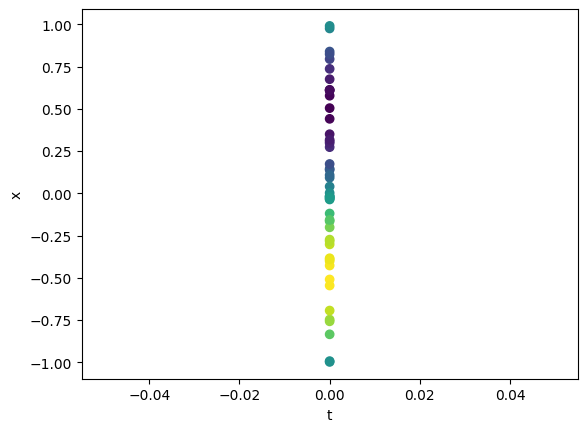

In [10]:
pl.scatter(t_0, x_0, c=u_0, marker='o', clim=(-1,1))
pl.xlabel("t")
pl.ylabel("x");

Figure 2. Initial Condition setup for the PDE.

# get data at boundaries of x at random t's



In [11]:
t_b = tf.random.uniform((n_b, 1), tmin, tmax, dtype="float32")
x_b = xmin + (xmax - xmin) * tf.keras.backend.random_bernoulli((n_b, 1), 0.5, dtype="float32")
X_b = tf.concat([t_b, x_b], axis=1)
X_b

<tf.Tensor: shape=(50, 2), dtype=float32, numpy=
array([[ 0.88968754, -1.        ],
       [ 0.12354946, -1.        ],
       [ 0.7718717 , -1.        ],
       [ 0.6850728 , -1.        ],
       [ 0.6442598 , -1.        ],
       [ 0.07745004, -1.        ],
       [ 0.75058556, -1.        ],
       [ 0.6250843 , -1.        ],
       [ 0.00772953,  1.        ],
       [ 0.55370283,  1.        ],
       [ 0.83894694,  1.        ],
       [ 0.43658102,  1.        ],
       [ 0.9566101 ,  1.        ],
       [ 0.7588576 , -1.        ],
       [ 0.8964343 , -1.        ],
       [ 0.44467843, -1.        ],
       [ 0.3243779 ,  1.        ],
       [ 0.3443855 ,  1.        ],
       [ 0.91262174,  1.        ],
       [ 0.77731085,  1.        ],
       [ 0.899588  ,  1.        ],
       [ 0.50426483, -1.        ],
       [ 0.45032525,  1.        ],
       [ 0.5939442 , -1.        ],
       [ 0.71862614,  1.        ],
       [ 0.91657436, -1.        ],
       [ 0.98180914, -1.        ],
      

# evaluate data at boundaries of x at random t's


In [12]:
u_b = fun_u_b(t_b, x_b)
u_b

<tf.Tensor: shape=(50, 1), dtype=float32, numpy=
array([[0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.]], dtype=float32)>

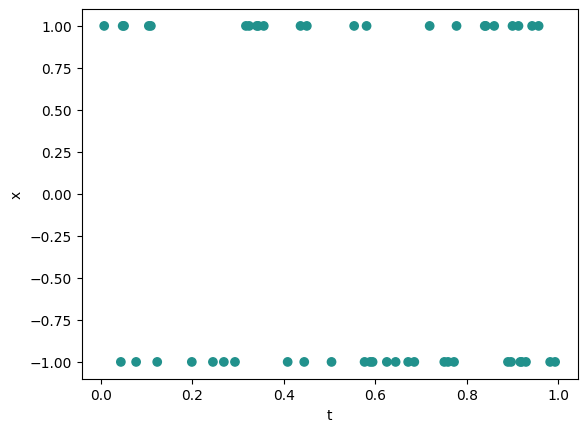

In [13]:
pl.scatter(t_b, x_b, c=u_b, marker='o', clim=(-1,1))
pl.xlabel("t")
pl.ylabel("x");

Figure 3. Boundary Conditions for the PDE, as we have data at x=-1 and x=1. We set the values at the boundary to be 0 for all times.

# get points inside the space at random where the function will be predicted

In [14]:
t_r = tf.random.uniform((n_r, 1), tmin, tmax, dtype="float32")
x_r = tf.random.uniform((n_r, 1), xmin, xmax, dtype="float32")
X_r = tf.concat([t_r, x_r], axis=1)
X_r

<tf.Tensor: shape=(10000, 2), dtype=float32, numpy=
array([[ 0.48962688, -0.15719008],
       [ 0.5857923 ,  0.16138387],
       [ 0.36451697, -0.43461084],
       ...,
       [ 0.9338294 ,  0.9995079 ],
       [ 0.11166203, -0.28287673],
       [ 0.00506091,  0.7726338 ]], dtype=float32)>

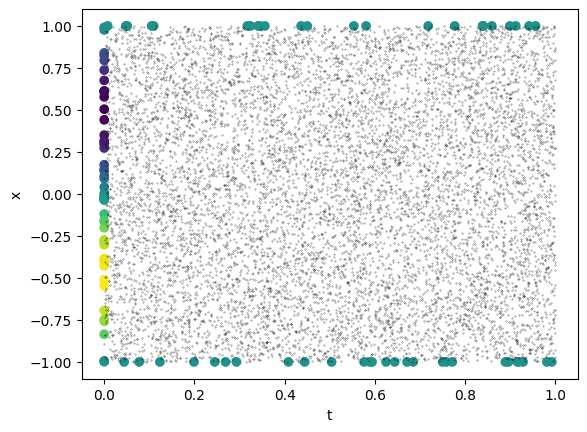

In [15]:
pl.scatter(t_0, x_0, c=u_0, marker='o', clim=(-1,1))
pl.scatter(t_b, x_b, c=u_b, marker='o', clim=(-1,1))
pl.scatter(t_r, x_r, c="k", marker='.', s=0.3, alpha=0.7, clim=(-1,1))
pl.xlabel("t")
pl.ylabel("x");

Figure 4. The initial and boundary conditions (colored), and the random points to evaluate the function at (grey).

In [16]:
#put boundary conditionns together
X = tf.concat([X_0, X_b], axis=0)
y = tf.concat([u_0, u_b], axis=0)
X.shape, y.shape


(TensorShape([100, 2]), TensorShape([100, 1]))

In [17]:
input_shape = X.shape[1:]

In [18]:
X.shape[1:]

TensorShape([2])

# create the model with simple loss

In [19]:

nnmodel = tf.keras.Sequential()
#input layer with 2 neurons for 2 dimensions
nnmodel.add(tf.keras.layers.InputLayer(input_shape = input_shape)) #input shape has dim 2
#8 hidden layers
for i in range(8):
  nnmodel.add(tf.keras.layers.Dense(16,activation="tanh")) #I chose 16 nodes for the dense layers, somewhat at random. I also tried relu activation function which seemed to work fine as well, but since we use tanh later, I use it here.

#output layer is 1D
nnmodel.add(tf.keras.layers.Dense(1)) #end with 1 node

In [20]:
optim = tf.keras.optimizers.Adam(learning_rate=0.001)

In [21]:
def customloss(u_true,u_pred):
  mse = tf.reduce_mean(tf.square(u_true-u_pred)) #mean squared error / L2
  return mse


In [22]:
nnmodel.compile(loss=customloss, optimizer=optim)

## train the model

In [23]:
history = nnmodel.fit(X, y, epochs=1000)

Epoch 1/1000
4/4 [==============================] - 8s 23ms/step - loss: 0.3391
Epoch 2/1000
4/4 [==============================] - 0s 9ms/step - loss: 0.2010
Epoch 3/1000
4/4 [==============================] - 0s 7ms/step - loss: 0.1737
Epoch 4/1000
4/4 [==============================] - 0s 6ms/step - loss: 0.1859
Epoch 5/1000
4/4 [==============================] - 0s 8ms/step - loss: 0.1834
Epoch 6/1000
4/4 [==============================] - 0s 7ms/step - loss: 0.1732
Epoch 7/1000
4/4 [==============================] - 0s 7ms/step - loss: 0.1685
Epoch 8/1000
4/4 [==============================] - 0s 7ms/step - loss: 0.1624
Epoch 9/1000
4/4 [==============================] - 0s 6ms/step - loss: 0.1611
Epoch 10/1000
4/4 [==============================] - 0s 6ms/step - loss: 0.1583
Epoch 11/1000
4/4 [==============================] - 0s 7ms/step - loss: 0.1543
Epoch 12/1000
4/4 [==============================] - 0s 7ms/step - loss: 0.1513
Epoch 13/1000
4/4 [=============================

Text(0, 0.5, 'loss')

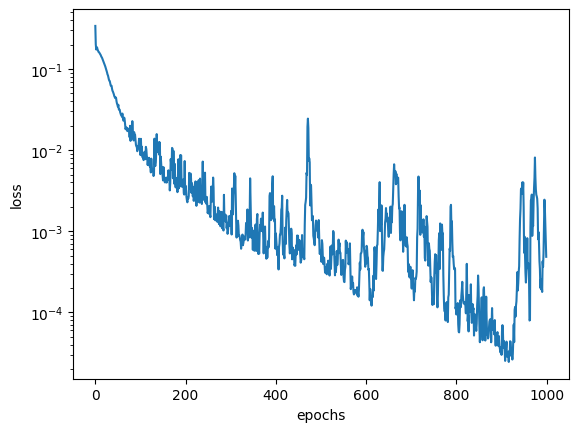

In [24]:
pl.semilogy(history.history["loss"])
pl.xlabel("epochs")
pl.ylabel("loss")

Figure 5. Loss function over epochs for the simple (L2) loss model. It's not very consistently decreasing, but the loss is consistently small, so not a huge issue.

## see the result

In [25]:
nnmodel.predict(tf.concat([t_r, x_r], axis=1))

313/313 [==============================] - 1s 2ms/step


array([[ 0.08019728],
       [ 0.06177519],
       [ 0.08560639],
       ...,
       [ 0.00542064],
       [ 0.31937456],
       [-0.67972034]], dtype=float32)

313/313 [==============================] - 1s 2ms/step


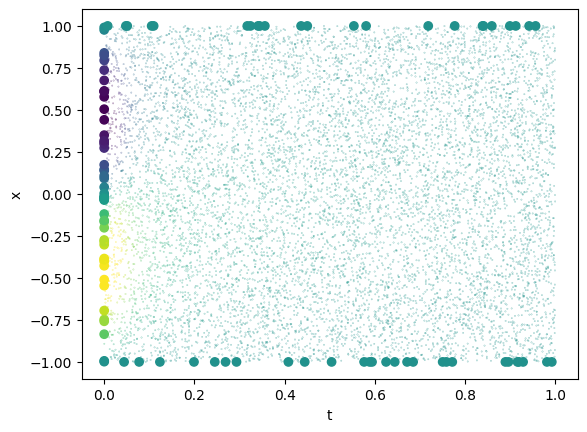

In [26]:
pl.scatter(t_0, x_0, c=u_0, marker='o', clim=(-1,1))
pl.scatter(t_b, x_b, c=u_b, marker='o', clim=(-1,1))
pl.scatter(t_r, x_r, c=nnmodel.predict(tf.concat([t_r, x_r], axis=1)), marker='.',
           s=0.2, alpha=0.7, clim=(-1,1))
pl.xlabel("t")
pl.ylabel("x");

Figure 6. Results of the simple-loss NN for the Burger Equations. We can see that the central points are more or less uniform, not matching the expected result-- we don't see a shock front!

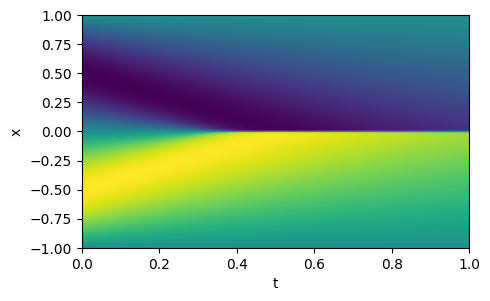

In [27]:
ax = pl.figure(figsize=(5,5)).add_subplot(111)
cb = ax.imshow(Z[::-1],extent=[0,1,-1,1], clim=(-1,1))
ax.set_xlabel("t")
ax.set_ylabel("x");
ax.set_aspect(0.3);


Figure 7. This is the expected result again, for comparison. Again, there's a clear shock front (rapid change in color) here, but not in our NN result.

show the accuracy for every point that you solved for

8/8 [==============================] - 0s 2ms/step


12.987446312056688

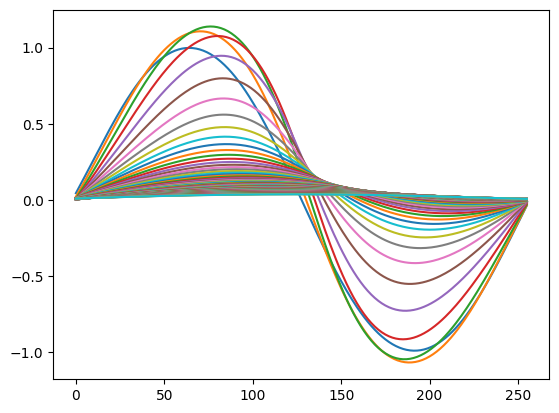

In [28]:
def L1accuracy(t, x, model):
  tmp_ = np.zeros((x.shape[0], 2), dtype="float32")
  tmp_[:,1] += x
  acc = 0
  for tt in range(t.shape[0]):
    tmp_[:,0] = t[tt]
    pl.plot(model.predict(tmp_))
    acc += (model.predict(tmp_) - Z[:,tt]).sum()


  return acc / np.prod(t.shape[0] * x.shape[0])
L1accuracy(t, x, nnmodel)

Figure 8. This figure plots the velocity (the result of the Burger Equation), u, as a function of position (0 to 256, which are the indexes of the position array, so take 0 --> x=-1 and 256 --> x=1). Each line with  a different color is the model prediciton for a different TIME, going from t=0 to t=1. So this plot represents the same thing as the plot in fig. 6, but in a different display. The accuracy score is calculated by summing the difference of the value of u (y axis here) for each point on the x axis (position) summed over each time (each line) for the true and predicted values. Thus, if the true and predicted values are similar, we will get a LOW value for the accuracy "score". Here, a score of ~62 means that we aren't very accurate over all the times we try. This agrees with what we will see in the next figure, where we start off accurate, but clearly deviate from the truth at later times.

8/8 [==============================] - 0s 2ms/step


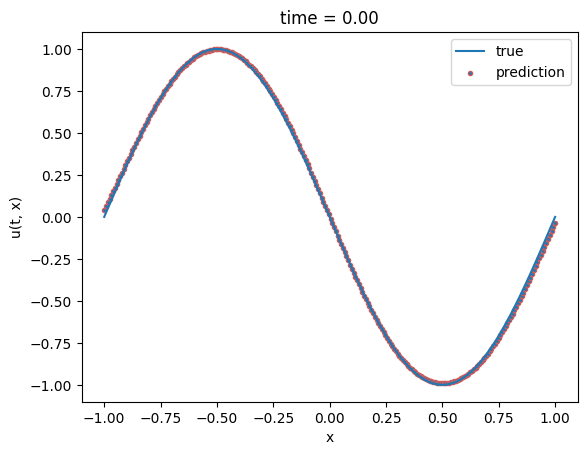

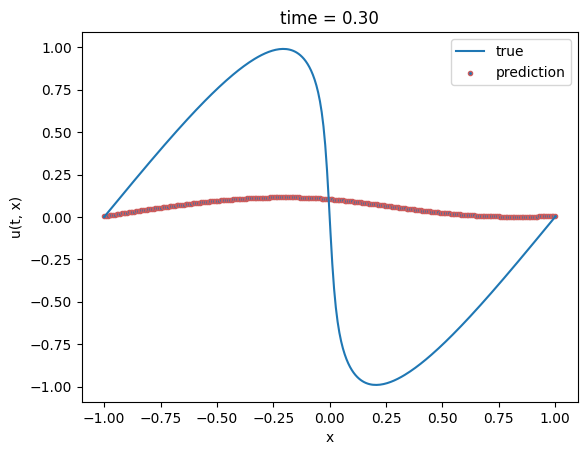

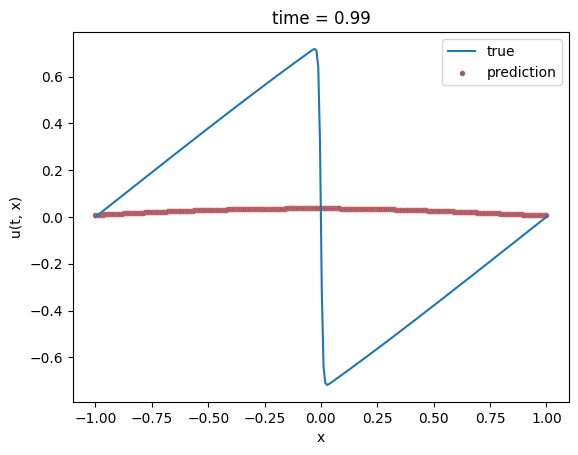

In [29]:
tmp_ = np.zeros((x.shape[0], 2), dtype="float32")
tmp_[:,1] += x
inds = [0, 30, -1]
for i in range(3):
  pl.figure()
  pl.title("time = %.2f"%t[inds[i]])
  pl.plot(x, Z[:,inds[i]], label="true")
  tmp_[:,0] = t[inds[i]]
  pl.scatter(x, nnmodel.predict(tmp_), marker='.', edgecolors="IndianRed",
             label="prediction")
  pl.xlabel("x")
  pl.ylabel("u(t, x)")
  pl.legend();


Figure 9. Evolution of the equations over time, with true values compared to prediction. The NN starts of predicting well enough, but quickly loses the shape as time evolves.

# create the model with complete loss

In [30]:
def get_pde(model, X_r):

  with tf.GradientTape(persistent=True) as tape:
      t, x = X_r[:,0:1], X_r[:,1:2]
      tape.watch(t)
      tape.watch(x)
      u = model(tf.concat([t, x], axis=1))
      u_x = tape.gradient(u,x)
      #print(u_x)
  u_t = tape.gradient(u, t)
  u_xx = tape.gradient(u_x, x)

  del tape # to save some memory

  return u, u_t, u_x, u_xx


In [31]:
def custom_loss(model, X_r, X, y):
    u_pred = model(X)
    L2 = customloss(y,u_pred)
    u, u_t, u_x, u_xx = get_pde(model,X_r)
    resid = fun_res(u,u_t,u_x,u_xx)
    loss = L2 + customloss(resid,0) #combine PDE with the original L2 loss
    return loss


In [32]:
def get_grad(model, X_r, X, y):
    # model derivatives for backprop
    with tf.GradientTape(persistent = True) as tape:
      tape.watch(model.trainable_variables)
      loss= custom_loss(model,X_r,X,y)
    g=tape.gradient(loss,model.trainable_variables)

    return loss, g

## train the model

In [33]:
import copy

In [34]:

pinn = tf.keras.Sequential() #same as before
#input layer with 2 neurons for 2 dimensions
pinn.add(tf.keras.layers.InputLayer(input_shape = input_shape))
#8 hidden layers
for i in range(8):
  pinn.add(tf.keras.layers.Dense(16,activation="tanh"))

#output layer is 1D
pinn.add(tf.keras.layers.Dense(1))

In [35]:
@tf.function
def train_step(model, X_r, X, y):

  loss, grad = get_grad(model, X_r, X, y)
  optim.apply_gradients(zip(grad, model.trainable_variables))
  return loss

optim = tf.keras.optimizers.Adam(learning_rate=0.005)
pinn.compile(loss=custom_loss, optimizer=optim) #change the loss and optimization

history = []
Nepochs = 5000
for i in range(Nepochs):
  loss = train_step(pinn, X_r, X, y)
  history.append(loss.numpy())
  # Output current loss after 50 iterates
  if i%50 == 0:
        print('It {:05d}: loss = {:10.8e}'.format(i,loss))



It 00000: loss = 2.88981050e-01
It 00050: loss = 9.17073786e-02
It 00100: loss = 7.26063550e-02
It 00150: loss = 6.41408414e-02
It 00200: loss = 5.12795188e-02
It 00250: loss = 4.81664687e-02
It 00300: loss = 4.70230281e-02
It 00350: loss = 3.72370444e-02
It 00400: loss = 5.24839684e-02
It 00450: loss = 2.62280330e-02
It 00500: loss = 2.22167373e-02
It 00550: loss = 3.95364799e-02
It 00600: loss = 9.50748287e-03
It 00650: loss = 6.86057704e-03
It 00700: loss = 5.51104546e-03
It 00750: loss = 7.25416094e-03
It 00800: loss = 4.01479267e-02
It 00850: loss = 3.28189554e-03
It 00900: loss = 3.71472235e-03
It 00950: loss = 5.26731741e-03
It 01000: loss = 1.97734889e-02
It 01050: loss = 2.65178527e-03
It 01100: loss = 1.16461674e-02
It 01150: loss = 4.50746994e-03
It 01200: loss = 3.12634697e-03
It 01250: loss = 1.79240201e-03
It 01300: loss = 1.73807773e-03
It 01350: loss = 2.14202143e-02
It 01400: loss = 2.43157358e-03
It 01450: loss = 1.28514401e-03
It 01500: loss = 1.10398803e-03
It 01550

313/313 [==============================] - 1s 2ms/step


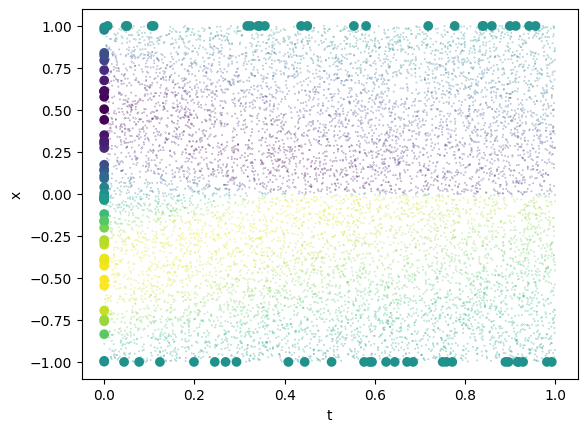

In [36]:
pl.scatter(t_0, x_0, c=u_0, marker='o', clim=(-1,1))
pl.scatter(t_b, x_b, c=u_b, marker='o', clim=(-1,1))
pl.scatter(t_r, x_r, c=pinn.predict(tf.concat([t_r, x_r], axis=1)), marker='.',
           s=0.2, alpha=0.7, clim=(-1,1))
pl.xlabel("t")
pl.ylabel("x");

Figure 10. Results of the PINN. Now we see something that looks quite similar to the expected result! we have the shock front (yellow--> purple) at x=0. This is a significant improvement over what we had before.

313/313 [==============================] - 1s 2ms/step


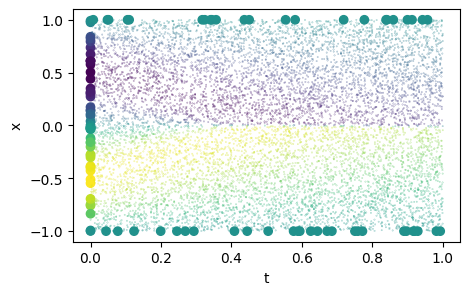

In [37]:
ax = pl.figure(figsize=(5,5)).add_subplot(111)
ax.set_xlabel("t")
ax.set_ylabel("x");
ax.scatter(t_0, x_0, c=u_0, marker='o', clim=(-1,1))
ax.scatter(t_b, x_b, c=u_b, marker='o', clim=(-1,1))
ax.scatter(t_r, x_r, c=pinn.predict(tf.concat([t_r, x_r], axis=1)),
           marker='.', s=0.2, alpha=0.7, clim=(-1,1))
pl.xlabel("t")
pl.ylabel("x");
ax.set_aspect(0.3);

Figure 11. Same as Fig. 9 but the size is different

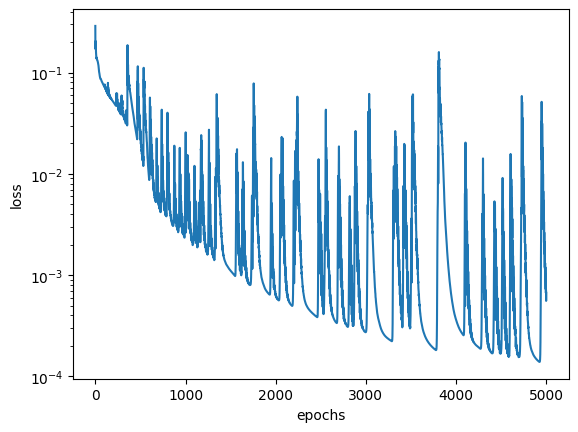

In [38]:
pl.semilogy(history)
pl.xlabel("epochs")
pl.ylabel("loss");

Figure 12. Loss function over 5000 epochs. Very noisy, and also isnt always that small really, so this is something we should worry about. We want to have something consistently small.

8/8 [==============================] - 0s 2ms/step


-1.8400241653715972

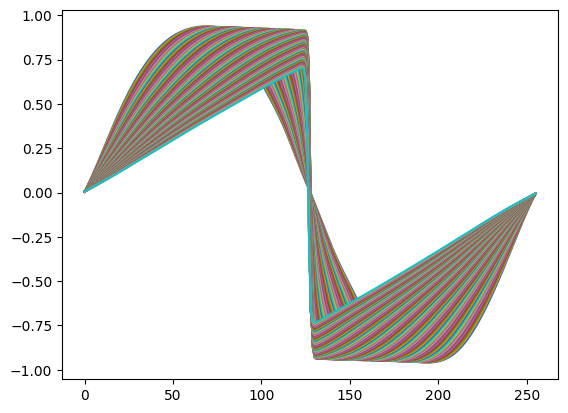

In [39]:
L1accuracy(t, x, pinn)

Figure 13. Accuracy plot for the PINN. The plot itself is clearly showing a more accurate result, because we start with a smooth curve at low times, but get to a sharp central part at later times, which is clearly the case in the truth (and we'll see that in the next figure). The accuracy score is -2 which is much closer to 0 than 64, so that agrees with the sentiment that we're more accurate.

# adjust the learning rate and trin some more
the loss was awfully noisy

In [40]:
from tensorflow.keras.backend import set_value
set_value(pinn.optimizer.lr, 0.0001)

In [41]:
Nepochs = 10000
for i in range(Nepochs):
  loss = train_step(pinn, X_r, X, y)
  history.append(loss.numpy())
  # Output current loss after 50 iterates
  if i%50 == 0:
        print('It {:05d}: loss = {:10.8e}'.format(i,loss))


It 00000: loss = 5.55466628e-04
It 00050: loss = 4.64486977e-04
It 00100: loss = 4.44855803e-04
It 00150: loss = 4.28192900e-04
It 00200: loss = 4.13020491e-04
It 00250: loss = 3.98863864e-04
It 00300: loss = 3.85502412e-04
It 00350: loss = 3.72818089e-04
It 00400: loss = 3.60751466e-04
It 00450: loss = 3.49260808e-04
It 00500: loss = 3.38319689e-04
It 00550: loss = 3.27921851e-04
It 00600: loss = 3.18058097e-04
It 00650: loss = 3.08709103e-04
It 00700: loss = 2.99852836e-04
It 00750: loss = 2.91462609e-04
It 00800: loss = 2.83514499e-04
It 00850: loss = 2.75981263e-04
It 00900: loss = 2.68839794e-04
It 00950: loss = 2.62072601e-04
It 01000: loss = 2.55659892e-04
It 01050: loss = 2.49583478e-04
It 01100: loss = 2.43828646e-04
It 01150: loss = 2.38373876e-04
It 01200: loss = 2.33210900e-04
It 01250: loss = 2.28320074e-04
It 01300: loss = 2.23688636e-04
It 01350: loss = 2.19301975e-04
It 01400: loss = 2.15146239e-04
It 01450: loss = 2.11210747e-04
It 01500: loss = 2.07480334e-04
It 01550

Text(0, 0.5, 'loss')

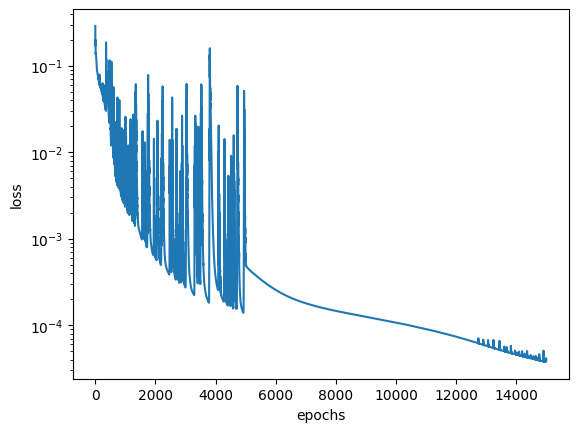

In [42]:
pl.semilogy(history)
pl.xlabel("epochs")
pl.ylabel("loss")

Figure 14. Full loss function after changing the learning rate. After that adjustment at 5k epochs, we can see the loss consistently decrease to small values. So we can be confident with this loss now.

313/313 [==============================] - 1s 2ms/step


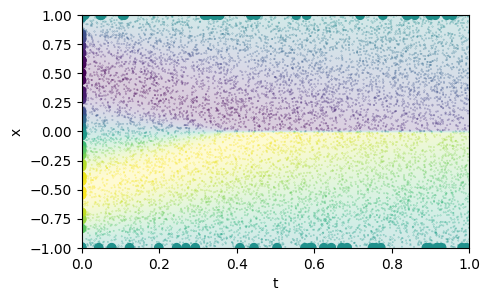

In [43]:
ax = pl.figure(figsize=(5,5)).add_subplot()
ax.imshow(Z[::-1],extent=[0,1,-1,1], alpha=0.2)
ax.scatter(t_0, x_0, c=u_0, marker='o', clim=(-1,1))
ax.scatter(t_b, x_b, c=u_b, marker='o', clim=(-1,1))
ax.scatter(t_r, x_r, c=pinn.predict(tf.concat([t_r, x_r], axis=1)),
           marker='.', s=0.2, alpha=0.7, clim=(-1,1))
ax.set_xlabel("t")
ax.set_ylabel("x");
ax.set_aspect(0.3);

Figure 15. Result of the PINN after the reduced learning rate epochs are added. We can see an even stronger correlation with the expected result (which is overlayed). We get a better result after more training with the reduced learning rate.

In [44]:
Nepochs = 10000
for i in range(Nepochs):
  loss = train_step(pinn, X_r, X, y)
  history.append(loss.numpy())
  # Output current loss after 50 iterates
  if i%50 == 0:
        print('It {:05d}: loss = {:10.8e}'.format(i,loss))

It 00000: loss = 3.78415352e-05
It 00050: loss = 3.70765774e-05
It 00100: loss = 3.67367429e-05
It 00150: loss = 3.64677871e-05
It 00200: loss = 3.61062157e-05
It 00250: loss = 3.89494962e-05
It 00300: loss = 3.55093252e-05
It 00350: loss = 3.75617237e-05
It 00400: loss = 3.49212351e-05
It 00450: loss = 3.46332999e-05
It 00500: loss = 3.48903850e-05
It 00550: loss = 3.40750084e-05
It 00600: loss = 3.38082282e-05
It 00650: loss = 3.43499232e-05
It 00700: loss = 3.32903437e-05
It 00750: loss = 3.30291514e-05
It 00800: loss = 3.29295872e-05
It 00850: loss = 3.25600486e-05
It 00900: loss = 3.22850974e-05
It 00950: loss = 3.21546577e-05
It 01000: loss = 3.18087259e-05
It 01050: loss = 3.15705074e-05
It 01100: loss = 3.21779407e-05
It 01150: loss = 3.11240001e-05
It 01200: loss = 3.16669320e-05
It 01250: loss = 3.06811235e-05
It 01300: loss = 3.04901278e-05
It 01350: loss = 3.05928552e-05
It 01400: loss = 3.00440242e-05
It 01450: loss = 3.02050848e-05
It 01500: loss = 2.96526068e-05
It 01550

Text(0, 0.5, 'loss')

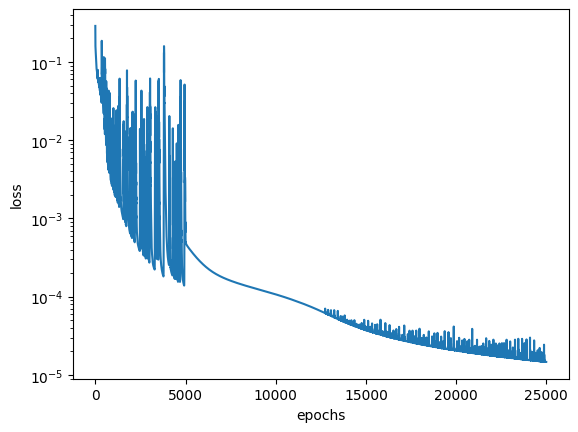

In [45]:
pl.semilogy(history)
pl.xlabel("epochs")
pl.ylabel("loss")

Figure 16. Loss function for another 10k epochs. We can see that the loss function is still decreasing, which means the training is useful, although it is becoming more inconsistent towards the end.

## final result

8/8 [==============================] - 0s 2ms/step


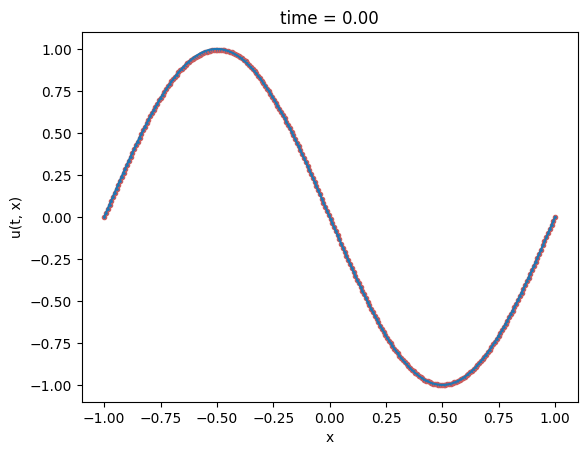

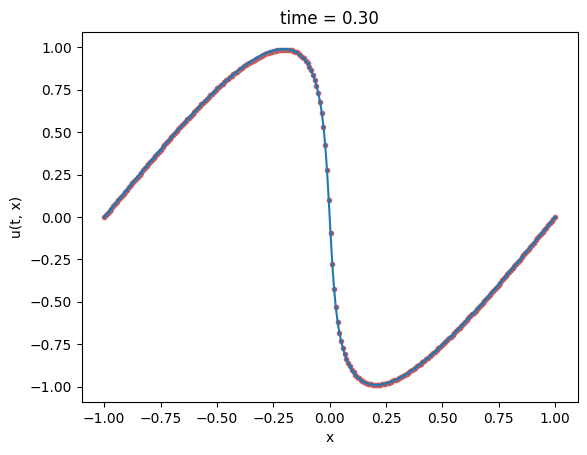

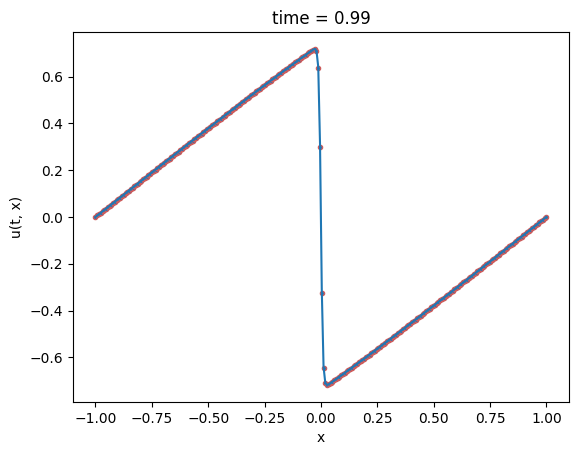

In [46]:
for i in range(3):
  pl.figure()
  pl.title("time = %.2f"%t[inds[i]])
  pl.plot(x, Z[:,inds[i]])
  tmp_[:,0] = t[inds[i]]
  pl.scatter(x, pinn.predict(tmp_), marker='.', edgecolors="IndianRed")
  pl.xlabel("x")
  pl.ylabel("u(t, x)");

Figure 17. Comparing the results of the burger equations at different times between the PINN prediction and true result. Whereas before, the predictions became innacurate after the first time, now we can see that the predictions pretty much match the expectations throughout. This agrees with the full result plot (see next figure).

313/313 [==============================] - 1s 2ms/step


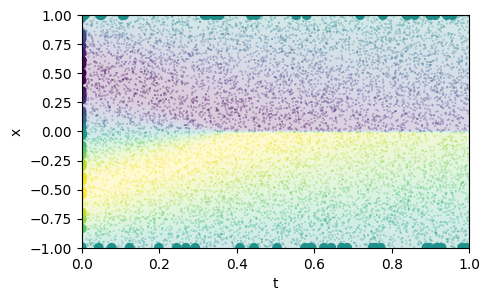

In [47]:
ax = pl.figure(figsize=(5,5)).add_subplot(111)
ax.imshow(Z[::-1], extent=[0,1,-1,1], alpha=0.2)
ax.scatter(t_0, x_0, c=u_0, marker='o', clim=(-1,1))
ax.scatter(t_b, x_b, c=u_b, marker='o', clim=(-1,1))
ax.scatter(t_r, x_r, c=pinn.predict(tf.concat([t_r, x_r], axis=1)),
           marker='.', s=0.2, alpha=0.7, clim=(-1,1))
ax.set_xlabel("t")
ax.set_ylabel("x");
ax.set_aspect(0.3)
#pl.colorbar();

Figure 18. Final result. We can see that there is excellent agreement between the predictions and true result, again overlayed with a small alpha value. The shock front is clearly visible at x=0.

8/8 [==============================] - 0s 2ms/step


-0.11508981555716805

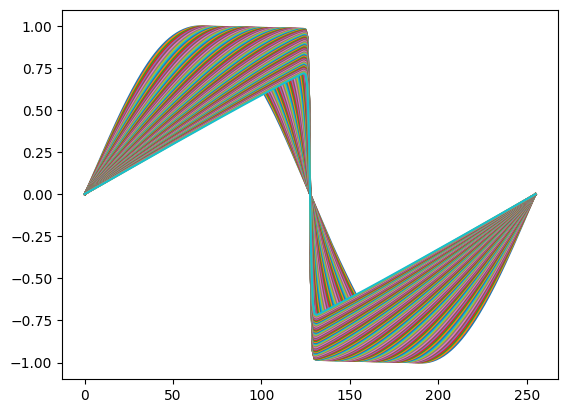

In [48]:
L1accuracy(t, x, pinn)

Figure 19. Final accuracy plot. We again see something closer to what we want, becuase we have the high curvature at low times, but extremely shart edges at later times. The accuracy is 10x better than before, so we're doing a very good job approximating the truth.